# Machine Learning Models

### HistGradientBoostingRegressor

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    median_absolute_error, r2_score, make_scorer
)
from tqdm import tqdm
import warnings
import pickle
import os
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# Paths for dataset, trained models, and evaluation reports.
# ============================================================
DATA_PATH = '/Users/sadra/Desktop/Total_Data.csv'
RESULT_DIR = '/Users/sadra/Desktop/Result/Models/'
REPORT_DIR = '/Users/sadra/Desktop/Result/Reports/'
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# ============================================================
# LOAD & PREPARE DATA
# Includes: loading dataset, column selection, cleaning, label encoding
# ============================================================
data = pd.read_csv(DATA_PATH, encoding='utf-8')
required_columns = ['Coumarin Type', 'Cancer Type', 'Coumarin Dose', 'Time', 'Viability']
data = data[required_columns].dropna()

# Convert dose to numeric and restrict doses ≤ 400
data['Coumarin Dose'] = pd.to_numeric(data['Coumarin Dose'], errors='coerce')
data = data[data['Coumarin Dose'] <= 400]

# Encode cancer types for ML models
label_encoder = LabelEncoder()
data['Cancer Type'] = label_encoder.fit_transform(data['Cancer Type'])

# ============================================================
# PROCESS EACH COUMARIN TYPE
# Each coumarin is processed independently to produce:
# - Reliability filtering via Gaussian Mixture Model
# - Model training using HistGradientBoostingRegressor
# - Full cross-validation metrics
# - Feature importance (CSV + TIFF plot)
# - Optimal dose/time predictions for viability≈50
# ============================================================
for coumarin in data['Coumarin Type'].unique():
    print(f"\n=== Processing {coumarin} ===")

    # Extract coumarin-specific subset
    coumarin_data = data[data['Coumarin Type'] == coumarin].copy()

    # Some compounds have an additional 96h measurement
    allowed_times = [24, 48, 72, 96] if coumarin.lower() == 'auraptene' else [24, 48, 72]
    coumarin_data = coumarin_data[coumarin_data['Time'].isin(allowed_times)]

    if coumarin_data.empty:
        print(f"⚠️ No valid time points for {coumarin}. Skipping...")
        continue

    # ------------------------------------------------------------
    # RELIABILITY FILTERING USING GMM
    # Identifies cancer types with sufficient sample size.
    # ------------------------------------------------------------
    cancer_counts = coumarin_data['Cancer Type'].value_counts().to_dict()
    count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(count_df[['Sample Count']])

    # Threshold = midpoint between two mixture components
    threshold = np.mean(gmm.means_.flatten())

    count_df['Reliability'] = count_df['Sample Count'].apply(
        lambda x: 'Reliable' if x >= threshold else 'Unreliable'
    )

    reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
    reliable_data = coumarin_data[coumarin_data['Cancer Type'].isin(reliable_cancers)].copy()

    print(f"Reliability threshold for {coumarin}: {threshold:.2f}")
    print(f"Reliable cancer types retained: {len(reliable_cancers)} of {len(cancer_counts)}")

    if reliable_data.empty:
        print(f"⚠️ No reliable data for {coumarin}. Skipping...")
        continue

    # ------------------------------------------------------------
    # MODEL TRAINING (HistGradientBoostingRegressor)
    # ------------------------------------------------------------
    X = reliable_data[['Coumarin Dose', 'Time', 'Cancer Type']]
    y = reliable_data['Viability']

    model = HistGradientBoostingRegressor(
        max_iter=200,
        max_depth=None,
        learning_rate=0.1,
        min_samples_leaf=20,
        max_bins=255,
        random_state=42
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Define scoring metrics
    scorers = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MedAE': make_scorer(median_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    # Cross-validation evaluation
    cv_results = {}
    for name, scorer in scorers.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        # Flip sign for error metrics
        if name in ['MSE', 'MAE', 'MedAE']:
            scores = -scores
        cv_results[name] = (round(scores.mean(), 2), round(scores.std(), 2))

    # Fit final model for reporting + predictions
    model.fit(X, y)
    y_pred_train = model.predict(X)

    # Training set evaluation
    train_results = {
        'MSE': (round(mean_squared_error(y, y_pred_train), 2), 0),
        'MAE': (round(mean_absolute_error(y, y_pred_train), 2), 0),
        'MedAE': (round(median_absolute_error(y, y_pred_train), 2), 0),
        'R2': (round(r2_score(y, y_pred_train), 2), 0)
    }

    # Save evaluation report
    eval_report = pd.DataFrame({
        'Metric': list(scorers.keys()),
        'Cross_Validation': [cv_results[m][0] for m in scorers.keys()],
        'CV_SD': [cv_results[m][1] for m in scorers.keys()],
        'Train': [train_results[m][0] for m in scorers.keys()],
        'Train_SD': [train_results[m][1] for m in scorers.keys()]
    })
    eval_report.to_csv(f'{REPORT_DIR}Evaluation_Report_{coumarin}.csv', index=False)
    print(f"\n--- Model Evaluation ({coumarin}) ---\n{eval_report}\n")

    # Save trained model
    with open(f'{RESULT_DIR}histgb_model_{coumarin}.pkl', 'wb') as f:
        pickle.dump(model, f)

    # ------------------------------------------------------------
    # FEATURE IMPORTANCE
    # Computed using model's built-in method or permutation fallback.
    # ------------------------------------------------------------
    feature_names = ['Coumarin Dose', 'Time', 'Cancer Type']

    try:
        importance = model.feature_importances_
    except AttributeError:
        from sklearn.inspection import permutation_importance
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        importance = result.importances_mean

    # Rank features
    sorted_idx = np.argsort(importance)
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importance = importance[sorted_idx]

    # Save importance table
    importance_df = pd.DataFrame({
        'Feature': sorted_features,
        'Importance': sorted_importance
    })
    importance_df.to_csv(
        f'{REPORT_DIR}Feature_Importance_{coumarin}_HistGradientBoostingRegressor.csv',
        index=False
    )

    # Save TIFF plot
    plt.figure(figsize=(8, 5))
    plt.barh(sorted_features, sorted_importance, color='black')
    plt.xlabel("Importance")
    plt.title(f"Feature Importance – {coumarin} – HistGradientBoostingRegressor")
    plt.tight_layout()
    plt.savefig(
        f'{REPORT_DIR}Feature_Importance_{coumarin}_HistGradientBoostingRegressor.tiff',
        format='tiff', dpi=300
    )
    plt.close()

    # ------------------------------------------------------------
    # OPTIMAL DOSE/TIME PREDICTION FOR TARGET VIABILITY 50
    # Scans a dose-time grid to find setting closest to viability=50.
    # ------------------------------------------------------------
    def predict_viability(cancer_code):
        predictions = []
        for dose in np.linspace(0, 400, 50):
            for time in allowed_times:
                viability = model.predict([[dose, time, cancer_code]])[0]
                predictions.append((dose, time, viability))
        df_pred = pd.DataFrame(predictions, columns=['Dose', 'Time', 'Viability'])
        df_pred['AbsError'] = abs(df_pred['Viability'] - 50)
        return df_pred.loc[df_pred['AbsError'].idxmin()]

    # Generate predictions for each reliable cancer type
    results = []
    for cancer_code in tqdm(reliable_cancers, desc=f"Predicting {coumarin}"):
        cancer_name = label_encoder.inverse_transform([cancer_code])[0]
        count = cancer_counts.get(cancer_code, 0)
        best = predict_viability(cancer_code)
        results.append({
            'Cancer Type': cancer_name,
            'Best Dose': best['Dose'],
            'Best Time': best['Time'],
            'Predicted Viability': best['Viability'],
            'Sample Count': count,
            'Reliability': 'Reliable'
        })

    # Save final prediction summary
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{REPORT_DIR}Prediction_Report_{coumarin}.csv', index=False)
    print(f"Prediction report for {coumarin} saved successfully.\n")

print("\n✅ All Coumarin types processed successfully.")

PermissionError: [Errno 13] Permission denied: '/Users'

### VotingRegressor (CatBoost, XGBoost, and LGBM)

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    median_absolute_error, r2_score, make_scorer
)
from tqdm import tqdm
import warnings
import pickle
import os
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# Paths for dataset, trained models, and evaluation reports.
# ============================================================
DATA_PATH = '/Users/sadra/Desktop/Total_Data.csv'
RESULT_DIR = '/Users/sadra/Desktop/Result/Models/'
REPORT_DIR = '/Users/sadra/Desktop/Result/Reports/'

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# ============================================================
# LOAD & CLEAN DATA
# Ensures proper encoding, required columns, dose ≤ 400.
# ============================================================

data = pd.read_csv(DATA_PATH, encoding='utf-8')
required_columns = ['Coumarin Type', 'Cancer Type', 'Coumarin Dose', 'Time', 'Viability']
data = data[required_columns].dropna()

data['Coumarin Dose'] = pd.to_numeric(data['Coumarin Dose'], errors='coerce')
data = data[data['Coumarin Dose'] <= 400]

# Encode cancer types globally for ML
label_encoder = LabelEncoder()
data['Cancer Type'] = label_encoder.fit_transform(data['Cancer Type'])

# ============================================================
# MAIN LOOP: PROCESS EACH COUMARIN TYPE
# Performs:
# - Reliability filtering via Gaussian Mixture Model
# - Model training with VotingRegressor
# - Cross-validation & training evaluation
# - Feature importance extraction & plotting
# - Optimal dose/time prediction for viability≈50
# ============================================================
for coumarin in data['Coumarin Type'].unique():
    print(f"\n=== Processing {coumarin} ===")

    # Allow 96h for Auraptene, otherwise standard times
    times = [24, 48, 72, 96] if coumarin.lower() == 'auraptene' else [24, 48, 72]
    coumarin_data = data[(data['Coumarin Type'] == coumarin) & (data['Time'].isin(times))].copy()

    if coumarin_data.empty:
        print(f"⚠️ No valid data for {coumarin}. Skipping...")
        continue

    # ------------------------------------------------------------
    # RELIABILITY FILTERING
    # Gaussian Mixture Model separates reliable vs unreliable cancer types
    # ------------------------------------------------------------
    cancer_counts = coumarin_data['Cancer Type'].value_counts().to_dict()
    count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(count_df[['Sample Count']])
    threshold = np.mean(gmm.means_.flatten())

    count_df['Reliability'] = count_df['Sample Count'].apply(
        lambda x: 'Reliable' if x >= threshold else 'Unreliable'
    )
    count_df.to_csv(f'{REPORT_DIR}Reliability_Threshold_{coumarin}.csv', index=False)

    reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
    reliable_data = coumarin_data[coumarin_data['Cancer Type'].isin(reliable_cancers)].copy()

    print(f"Reliability threshold for {coumarin}: {threshold:.2f}")
    print(f"Reliable cancer types retained: {len(reliable_cancers)} of {len(cancer_counts)}")

    if reliable_data.empty:
        print(f"⚠️ No reliable data for {coumarin}. Skipping...")
        continue

    # ------------------------------------------------------------
    # MODEL TRAINING
    # Ensemble of CatBoost, XGBoost, and LightGBM using VotingRegressor
    # ------------------------------------------------------------
    X = reliable_data[['Coumarin Dose', 'Time', 'Cancer Type']]
    y = reliable_data['Viability']

    catboost_model = CatBoostRegressor(n_estimators=200, learning_rate=0.1, depth=5, verbose=0, random_state=42)
    xgb_model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, verbosity=0, random_state=42)
    lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1, random_state=42)

    ensemble_model = VotingRegressor([
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Metrics for CV and training evaluation
    metrics = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MedAE': make_scorer(median_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    # Cross-validation evaluation
    cv_results = {}
    for name, scorer in metrics.items():
        scores = cross_val_score(ensemble_model, X, y, cv=kf, scoring=scorer)
        if name in ['MSE', 'MAE', 'MedAE']:
            scores = -scores
        cv_results[name] = (round(scores.mean(), 2), round(scores.std(), 2))

    # Fit final model for training evaluation & predictions
    ensemble_model.fit(X, y)
    y_pred = ensemble_model.predict(X)

    train_results = {
        'MSE': (round(mean_squared_error(y, y_pred), 2), 0),
        'MAE': (round(mean_absolute_error(y, y_pred), 2), 0),
        'MedAE': (round(median_absolute_error(y, y_pred), 2), 0),
        'R2': (round(r2_score(y, y_pred), 2), 0)
    }

    # ------------------------------------------------------------
    # SAVE EVALUATION REPORT
    # ------------------------------------------------------------
    eval_report = pd.DataFrame({
        'Metric': list(metrics.keys()),
        'Cross_Validation': [cv_results[m][0] for m in metrics.keys()],
        'CV_SD': [cv_results[m][1] for m in metrics.keys()],
        'Train': [train_results[m][0] for m in metrics.keys()],
        'Train_SD': [train_results[m][1] for m in metrics.keys()]
    })
    eval_report.to_csv(f'{REPORT_DIR}Evaluation_Report_{coumarin}.csv', index=False)
    print(eval_report)

    # Save trained ensemble model
    with open(f"{RESULT_DIR}voting_model_{coumarin}.pkl", 'wb') as f:
        pickle.dump(ensemble_model, f)

    # ------------------------------------------------------------
    # FEATURE IMPORTANCE
    # Mean importance across all base models
    # ------------------------------------------------------------
    feature_names = ['Coumarin Dose', 'Time', 'Cancer Type']

    fitted_cat = ensemble_model.named_estimators_['catboost']
    fitted_xgb = ensemble_model.named_estimators_['xgb']
    fitted_lgbm = ensemble_model.named_estimators_['lgbm']

    cat_imp = fitted_cat.get_feature_importance(Pool(X, y))
    xgb_imp = fitted_xgb.feature_importances_
    lgbm_imp = fitted_lgbm.feature_importances_

    all_importances = np.vstack([cat_imp, xgb_imp, lgbm_imp])
    ensemble_imp = all_importances.mean(axis=0)

    sorted_idx = np.argsort(ensemble_imp)
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importance = ensemble_imp[sorted_idx]

    importance_df = pd.DataFrame({
        'Feature': sorted_features,
        'Ensemble Importance': sorted_importance,
        'CatBoost': cat_imp[sorted_idx],
        'XGBoost': xgb_imp[sorted_idx],
        'LightGBM': lgbm_imp[sorted_idx]
    })
    importance_df.to_csv(f"{REPORT_DIR}Feature_Importance_{coumarin}_VotingRegressor.csv", index=False)

    # Plot feature importance TIFF
    plt.figure(figsize=(8, 5))
    plt.barh(sorted_features, sorted_importance, color='black')
    plt.xlabel("Importance")
    plt.title(f"Feature Importance – {coumarin} – VotingRegressor")
    plt.tight_layout()
    plt.savefig(f"{REPORT_DIR}Feature_Importance_{coumarin}_VotingRegressor.tiff",
                format="tiff", dpi=300)
    plt.close()

    # ------------------------------------------------------------
    # PREDICTION REPORT
    # Optimal dose/time per reliable cancer type to achieve viability≈50
    # ------------------------------------------------------------
    def predict_viability(cancer_code):
        predictions = []
        for dose in np.linspace(0, 400, 50):
            for time in times:
                v = ensemble_model.predict([[dose, time, cancer_code]])[0]
                predictions.append((dose, time, v))
        df = pd.DataFrame(predictions, columns=['Dose', 'Time', 'Viability'])
        df['AbsError'] = abs(df['Viability'] - 50)
        return df.loc[df['AbsError'].idxmin()]

    results = []
    for cancer_code in tqdm(reliable_cancers, desc=f"Predicting {coumarin}"):
        cancer_name = label_encoder.inverse_transform([cancer_code])[0]
        count = cancer_counts.get(cancer_code, 0)
        best = predict_viability(cancer_code)

        results.append({
            'Cancer Type': cancer_name,
            'Best Dose': best['Dose'],
            'Best Time': best['Time'],
            'Predicted Viability': best['Viability'],
            'Sample Count': count,
            'Reliability': "Reliable"
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{REPORT_DIR}Prediction_Report_{coumarin}.csv", index=False)

print("\n✅ ALL COUMARINS PROCESSED SUCCESSFULLY")

### CatBoostRegressor

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, make_scorer
from tqdm import tqdm
import warnings
import pickle
import os
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# ============================================================
DATA_PATH = '/Users/sadra/Desktop/Total_Data.csv'
RESULT_DIR = '/Users/sadra/Desktop/Result/Models/'
REPORT_DIR = '/Users/sadra/Desktop/Result/Reports/'

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# ============================================================
# LOAD & CLEAN DATA
# ============================================================
data = pd.read_csv(DATA_PATH, encoding='utf-8')
required_columns = ['Coumarin Type', 'Cancer Type', 'Coumarin Dose', 'Time', 'Viability']
data = data[required_columns].dropna()

data['Coumarin Dose'] = pd.to_numeric(data['Coumarin Dose'], errors='coerce')
data = data[data['Coumarin Dose'] <= 400]

# Exclude Scopoletin
data = data[data['Coumarin Type'].str.lower() != 'scopoletin']
print(f"✅ Scopoletin data excluded. Remaining coumarins: {data['Coumarin Type'].unique().tolist()}")

# Encode cancer types globally
label_encoder = LabelEncoder()
data['Cancer Type'] = label_encoder.fit_transform(data['Cancer Type'])

# ============================================================
# MAIN LOOP: PROCESS EACH COUMARIN TYPE
# ============================================================
for coumarin in data['Coumarin Type'].unique():
    print(f"\n=== Processing {coumarin} ===")
    coumarin_data = data[data['Coumarin Type'] == coumarin].copy()

    allowed_times = [24, 48, 72, 96] if coumarin.lower() == 'auraptene' else [24, 48, 72]
    coumarin_data = coumarin_data[coumarin_data['Time'].isin(allowed_times)]

    if coumarin_data.empty:
        print(f"⚠️ No valid time points for {coumarin}. Skipping...")
        continue

    # ------------------------------------------------------------
    # RELIABILITY FILTERING
    # ------------------------------------------------------------
    cancer_counts = coumarin_data['Cancer Type'].value_counts().to_dict()
    count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(count_df[['Sample Count']])
    threshold = np.mean(gmm.means_.flatten())

    count_df['Reliability'] = count_df['Sample Count'].apply(
        lambda x: 'Reliable' if x >= threshold else 'Unreliable'
    )
    count_df.to_csv(f'{REPORT_DIR}Reliability_Threshold_{coumarin}.csv', index=False)

    reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
    reliable_data = coumarin_data[coumarin_data['Cancer Type'].isin(reliable_cancers)].copy()

    print(f"Reliability threshold for {coumarin}: {threshold:.2f}")
    print(f"Reliable cancer types retained: {len(reliable_cancers)} of {len(cancer_counts)}")

    if reliable_data.empty:
        print(f"⚠️ No reliable data for {coumarin}. Skipping...")
        continue

    # ------------------------------------------------------------
    # MODEL TRAINING (CatBoost)
    # ------------------------------------------------------------
    X = reliable_data[['Coumarin Dose', 'Time', 'Cancer Type']]
    y = reliable_data['Viability']

    model = CatBoostRegressor(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        random_seed=42,
        verbose=False
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scorers = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MedAE': make_scorer(median_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    # Cross-validation
    cv_results = {}
    for name, scorer in scorers.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        if name in ['MSE', 'MAE', 'MedAE']:
            scores = -scores
        cv_results[name] = (round(scores.mean(), 2), round(scores.std(), 2))

    # Fit final model
    model.fit(X, y)
    y_pred_train = model.predict(X)
    train_results = {
        'MSE': (round(mean_squared_error(y, y_pred_train), 2), 0),
        'MAE': (round(mean_absolute_error(y, y_pred_train), 2), 0),
        'MedAE': (round(median_absolute_error(y, y_pred_train), 2), 0),
        'R2': (round(r2_score(y, y_pred_train), 2), 0)
    }

    # ------------------------------------------------------------
    # EVALUATION REPORT
    # ------------------------------------------------------------
    eval_report = pd.DataFrame({
        'Metric': list(scorers.keys()),
        'Cross_Validation': [cv_results[m][0] for m in scorers.keys()],
        'CV_SD': [cv_results[m][1] for m in scorers.keys()],
        'Train': [train_results[m][0] for m in scorers.keys()],
        'Train_SD': [train_results[m][1] for m in scorers.keys()]
    })
    eval_report.to_csv(f'{REPORT_DIR}Evaluation_Report_{coumarin}.csv', index=False)
    print(f"\n--- Model Evaluation ({coumarin}) ---\n{eval_report}\n")

    # Save model
    with open(f'{RESULT_DIR}catboost_model_{coumarin}.pkl', 'wb') as f:
        pickle.dump(model, f)

    # ------------------------------------------------------------
    # FEATURE IMPORTANCE
    # ------------------------------------------------------------
    feature_names = ['Coumarin Dose', 'Time', 'Cancer Type']
    cat_pool = Pool(X, y)
    importance = model.get_feature_importance(cat_pool)

    sorted_idx = np.argsort(importance)
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importance = importance[sorted_idx]

    importance_df = pd.DataFrame({
        'Feature': sorted_features,
        'Importance': sorted_importance
    })
    importance_df.to_csv(f'{REPORT_DIR}Feature_Importance_{coumarin}_CatBoostRegressor.csv', index=False)

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_features, sorted_importance, color='black')
    plt.xlabel("Importance")
    plt.title(f"Feature Importance – {coumarin} – CatBoostRegressor")
    plt.tight_layout()
    plt.savefig(f'{REPORT_DIR}Feature_Importance_{coumarin}_CatBoostRegressor.tiff', format='tiff', dpi=300)
    plt.close()

    # ------------------------------------------------------------
    # PREDICTION REPORT
    # ------------------------------------------------------------
    def predict_viability(cancer_code):
        predictions = []
        for dose in np.linspace(0, 400, 50):
            for time in allowed_times:
                viability = model.predict([[dose, time, cancer_code]])[0]
                predictions.append((dose, time, viability))
        df_pred = pd.DataFrame(predictions, columns=['Dose', 'Time', 'Viability'])
        df_pred['AbsError'] = abs(df_pred['Viability'] - 50)
        return df_pred.loc[df_pred['AbsError'].idxmin()]

    results = []
    for cancer_code in tqdm(reliable_cancers, desc=f"Predicting {coumarin}"):
        cancer_name = label_encoder.inverse_transform([cancer_code])[0]
        count = cancer_counts.get(cancer_code, 0)
        best = predict_viability(cancer_code)
        results.append({
            'Cancer Type': cancer_name,
            'Best Dose': best['Dose'],
            'Best Time': best['Time'],
            'Predicted Viability': best['Viability'],
            'Sample Count': count,
            'Reliability': 'Reliable'
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{REPORT_DIR}Prediction_Report_{coumarin}.csv', index=False)
    print(f"\nPrediction report for {coumarin} saved successfully.\n")

print("\n✅ All Coumarin types processed successfully.")

### RandomForestRegressor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, make_scorer
from tqdm import tqdm
import warnings
import pickle
import os
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ============================================================
# CONFIGURATION
# ============================================================
DATA_PATH = '/Users/sadra/Desktop/Total_Data.csv'
RESULT_DIR = '/Users/sadra/Desktop/Result/Models/'
REPORT_DIR = '/Users/sadra/Desktop/Result/Reports/'

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# ============================================================
# LOAD & CLEAN DATA
# ============================================================
data = pd.read_csv(DATA_PATH, encoding='utf-8')
required_columns = ['Coumarin Type', 'Cancer Type', 'Coumarin Dose', 'Time', 'Viability']
data = data[required_columns].dropna()

data['Coumarin Dose'] = pd.to_numeric(data['Coumarin Dose'], errors='coerce')
data = data[data['Coumarin Dose'] <= 400]

# Exclude Scopoletin
data = data[data['Coumarin Type'].str.lower() != 'scopoletin']
print(f"✅ Scopoletin data excluded. Remaining coumarins: {data['Coumarin Type'].unique().tolist()}")

# ============================================================
# MAIN LOOP: PROCESS EACH COUMARIN TYPE
# ============================================================
for coumarin in data['Coumarin Type'].unique():
    print(f"\n=== Processing {coumarin} ===")
    
    # Time filter
    times = [24, 48, 72, 96] if coumarin.lower() == 'auraptene' else [24, 48, 72]
    coumarin_data = data[(data['Coumarin Type'] == coumarin) & (data['Time'].isin(times))].copy()

    if coumarin_data.empty:
        print(f"⚠️ No valid time points for {coumarin}. Skipping...")
        continue

    # Encode cancer types for this coumarin
    label_encoder = LabelEncoder()
    coumarin_data['Cancer Type'] = label_encoder.fit_transform(coumarin_data['Cancer Type'])

    # ------------------------------------------------------------
    # RELIABILITY FILTERING
    # ------------------------------------------------------------
    cancer_counts = coumarin_data['Cancer Type'].value_counts().to_dict()
    count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(count_df[['Sample Count']])
    threshold = np.mean(gmm.means_.flatten())

    count_df['Reliability'] = count_df['Sample Count'].apply(lambda x: 'Reliable' if x >= threshold else 'Unreliable')
    count_df.to_csv(f'{REPORT_DIR}Reliability_Threshold_{coumarin}.csv', index=False)

    reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
    reliable_data = coumarin_data[coumarin_data['Cancer Type'].isin(reliable_cancers)].copy()

    print(f"Reliability threshold for {coumarin}: {threshold:.2f}")
    print(f"Reliable cancer types retained: {len(reliable_cancers)} of {len(cancer_counts)}")

    if reliable_data.empty:
        print(f"⚠️ No reliable data for {coumarin}. Skipping...")
        continue

    # ------------------------------------------------------------
    # MODEL TRAINING (RandomForest)
    # ------------------------------------------------------------
    X = reliable_data[['Coumarin Dose', 'Time', 'Cancer Type']]
    y = reliable_data['Viability']

    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='log2',
        random_state=42,
        n_jobs=-1
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scorers = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'MedAE': make_scorer(median_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

    cv_results = {}
    for name, scorer in scorers.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        if name in ['MSE', 'MAE', 'MedAE']:
            scores = -scores
        cv_results[name] = (round(scores.mean(), 2), round(scores.std(), 2))

    # Fit final model
    model.fit(X, y)
    y_train_pred = model.predict(X)
    train_results = {
        'MSE': (round(mean_squared_error(y, y_train_pred), 2), 0),
        'MAE': (round(mean_absolute_error(y, y_train_pred), 2), 0),
        'MedAE': (round(median_absolute_error(y, y_train_pred), 2), 0),
        'R2': (round(r2_score(y, y_train_pred), 2), 0)
    }

    # ------------------------------------------------------------
    # EVALUATION REPORT
    # ------------------------------------------------------------
    eval_report = pd.DataFrame({
        'Metric': list(scorers.keys()),
        'Cross_Validation': [cv_results[m][0] for m in scorers.keys()],
        'CV_SD': [cv_results[m][1] for m in scorers.keys()],
        'Train': [train_results[m][0] for m in scorers.keys()],
        'Train_SD': [train_results[m][1] for m in scorers.keys()]
    })
    eval_report.to_csv(f'{REPORT_DIR}Evaluation_Report_{coumarin}.csv', index=False)
    print(f"\n--- Model Evaluation ({coumarin}) ---\n{eval_report}\n")

    # Save model
    with open(f'{RESULT_DIR}rf_model_{coumarin}.pkl', 'wb') as f:
        pickle.dump(model, f)

    # ------------------------------------------------------------
    # FEATURE IMPORTANCE
    # ------------------------------------------------------------
    feature_names = ['Coumarin Dose', 'Time', 'Cancer Type']
    importance = model.feature_importances_

    sorted_idx = np.argsort(importance)
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importance = importance[sorted_idx]

    importance_df = pd.DataFrame({
        'Feature': sorted_features,
        'Importance': sorted_importance
    })
    importance_df.to_csv(f'{REPORT_DIR}Feature_Importance_{coumarin}_RandomForestRegressor.csv', index=False)

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_features, sorted_importance, color='black')
    plt.xlabel("Importance")
    plt.title(f"Feature Importance – {coumarin} – RandomForestRegressor")
    plt.tight_layout()
    plt.savefig(f'{REPORT_DIR}Feature_Importance_{coumarin}_RandomForestRegressor.tiff', format='tiff', dpi=300)
    plt.close()

    # ------------------------------------------------------------
    # PREDICTION REPORT
    # ------------------------------------------------------------
    def predict_viability(cancer_code):
        predictions = []
        for dose in np.linspace(0, 400, 50):
            for time in times:
                viability = model.predict([[dose, time, cancer_code]])[0]
                predictions.append((dose, time, viability))
        df_pred = pd.DataFrame(predictions, columns=['Dose', 'Time', 'Viability'])
        df_pred['AbsError'] = abs(df_pred['Viability'] - 50)
        return df_pred.loc[df_pred['AbsError'].idxmin()]

    results = []
    for cancer_code in tqdm(reliable_cancers, desc=f"Predicting {coumarin}"):
        cancer_name = label_encoder.inverse_transform([cancer_code])[0]
        count = cancer_counts.get(cancer_code, 0)
        best = predict_viability(cancer_code)
        results.append({
            'Cancer Type': cancer_name,
            'Best Dose': best['Dose'],
            'Best Time': best['Time'],
            'Predicted Viability': best['Viability'],
            'Sample Count': count,
            'Reliability': 'Reliable'
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{REPORT_DIR}Prediction_Report_{coumarin}.csv', index=False)
    print(f"\nPrediction report for {coumarin} saved successfully.\n")

print("\n✅ All Coumarin types processed successfully.")

## Weighted Median

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === USER PATHS ===
main_path = '/Users/sadra/Desktop/Result/Report ML Models'
save_dir = '/Users/sadra/Desktop/Result/Fig_ML'
os.makedirs(save_dir, exist_ok=True)

# === Marker and color configuration ===
marker_styles = ['o', 's', '^', 'D', 'P', '*', 'X', 'v', '<', '>']
color_map = plt.cm.tab10.colors

# === Weighted median helper ===
def weighted_median(values, weights):
    """Compute weighted median."""
    values, weights = np.array(values), np.array(weights)
    sorter = np.argsort(values)
    values, weights = values[sorter], weights[sorter]
    cumsum = np.cumsum(weights)
    cutoff = weights.sum() / 2.0
    return values[np.searchsorted(cumsum, cutoff)]

# === Identify model report directories ===
report_dirs = [d for d in os.listdir(main_path) if d.startswith('Reports')]
model_names = [d.replace('Reports ', '') for d in report_dirs]

# === Store data grouped by coumarin ===
coumarin_data = {}
r2_weights = {}

# === Read R² scores for each model & coumarin ===
for model_name, report_dir in zip(model_names, report_dirs):
    model_path = os.path.join(main_path, report_dir)
    for file in os.listdir(model_path):
        if file.startswith('Evaluation_Report_') and file.endswith('.csv'):
            coumarin = file.replace('Evaluation_Report_', '').replace('.csv', '')
            eval_df = pd.read_csv(os.path.join(model_path, file))
            eval_df.columns = [c.strip() for c in eval_df.columns]

            # Extract R² by Metric label
            r2_row = eval_df[eval_df['Metric'].str.contains('R2', case=False, na=False)]
            if not r2_row.empty:
                try:
                    r2_value = float(r2_row['Cross_Validation'].values[0])
                    r2_weights[(model_name, coumarin)] = r2_value
                except Exception:
                    continue

# === Read prediction reports ===
for model_idx, report_dir in enumerate(report_dirs):
    model_name = model_names[model_idx]
    model_path = os.path.join(main_path, report_dir)

    for file in os.listdir(model_path):
        if file.startswith('Prediction_Report_') and file.endswith('.csv'):
            coumarin = file.replace('Prediction_Report_', '').replace('.csv', '')
            df = pd.read_csv(os.path.join(model_path, file))
            df.columns = [c.strip() for c in df.columns]

            if not {'Cancer Type', 'Best Dose', 'Best Time'}.issubset(df.columns):
                continue

            df['Model'] = model_name
            df['Coumarin'] = coumarin

            # Filter allowed times
            allowed_times = [24, 48, 72, 96] if coumarin.lower() == 'auraptene' else [24, 48, 72]
            df = df[df['Best Time'].isin(allowed_times)]

            if coumarin not in coumarin_data:
                coumarin_data[coumarin] = []
            coumarin_data[coumarin].append(df)

# === Results storage ===
results = []

# === Plot for each coumarin ===
for coumarin, df_list in coumarin_data.items():
    combined_df = pd.concat(df_list, ignore_index=True)
    cancer_types = combined_df['Cancer Type'].unique()
    n_cancer = len(cancer_types)

    # Grid layout
    n_cols = int(n_cancer ** 0.5) + 1
    n_rows = (n_cancer + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    # Draw black border around entire figure
    for spine in ['top', 'bottom', 'left', 'right']:
        for ax in axes:
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(1.5)

    # Add coumarin name on top center
    fig.suptitle(coumarin, fontsize=16, fontweight='bold', y=1.02)

    # Compute average R²
    r2_list = [r2_weights.get((model, coumarin), np.nan) for model in model_names]
    avg_r2 = np.nanmean(r2_list)

    for idx, cancer in enumerate(cancer_types):
        ax = axes[idx]
        cancer_df = combined_df[combined_df['Cancer Type'] == cancer]

        model_times, model_doses, model_wts = [], [], []
        for model_idx, model in enumerate(model_names):
            model_df = cancer_df[cancer_df['Model'] == model]
            if model_df.empty:
                continue
            r2_val = r2_weights.get((model, coumarin), np.nan)
            if np.isnan(r2_val):
                continue

            t_vals = model_df['Best Time'].values
            d_vals = model_df['Best Dose'].values
            for ti, di in zip(t_vals, d_vals):
                model_times.append(ti)
                model_doses.append(di)
                model_wts.append(r2_val)

            ax.scatter(
                t_vals,
                d_vals,
                label=model,
                color=color_map[model_idx % len(color_map)],
                marker=marker_styles[model_idx % len(marker_styles)],
                s=80,
                alpha=0.85
            )

        # Weighted Median
        if model_times and model_doses:
            weighted_time = weighted_median(model_times, model_wts)
            weighted_dose = weighted_median(model_doses, model_wts)

            ax.scatter(weighted_time, weighted_dose,
                        facecolors='none',
                        edgecolors='black',
                        linewidths=2,
                        marker='s',
                        s=120,
                        label='Weighted Median')

            results.append({
                'Coumarin': coumarin,
                'Cancer Type': cancer,
                'Weighted Median Time': weighted_time,
                'Weighted Median Dose': weighted_dose
            })

        ax.set_title(cancer, fontsize=10)
        ax.set_xlabel('Best Time (h)')
        ax.set_ylabel('Best Dose')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_xticks([24, 48, 72, 96] if coumarin.lower() == 'auraptene' else [24, 48, 72])

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # Legend for Auraptene only
    if coumarin.lower() == 'auraptene':
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, 0),
                   ncol=1, title='Models', fontsize=9, title_fontsize=10, frameon=True)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
    else:
        plt.tight_layout()

    # Print average R²
    print(f"\n▸ Coumarin: {coumarin}")
    if np.isnan(avg_r2):
        print("   ⚠️ No valid R² values found for this coumarin.")
    else:
        print(f"   Average R² across models: {avg_r2:.4f}")

    # Save figures
    coumarin_folder = os.path.join(save_dir, coumarin)
    os.makedirs(coumarin_folder, exist_ok=True)
    fig_path_tiff = os.path.join(coumarin_folder, f'{coumarin}_WeightedMedian.tiff')
    fig_path_png = os.path.join(coumarin_folder, f'{coumarin}_WeightedMedian.png')
    plt.savefig(fig_path_tiff, format='tiff', dpi=300, bbox_inches='tight')
    plt.savefig(fig_path_png, format='png', dpi=300, bbox_inches='tight')
    plt.close(fig)

# Save weighted median results
results_df = pd.DataFrame(results)
results_path = os.path.join(save_dir, 'WeightedMedian_Consensus.csv')
results_df.to_csv(results_path, index=False)

print("\n✅ Weighted Median Aggregation completed successfully.")
print("Results saved to:", results_path)

# Plots

### Dose - Time - Regressors

#### Aur

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, QuantileRegressor
import pandas as pd
import seaborn as sns
from adjustText import adjust_text  
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Seaborn style
sns.set(style="whitegrid", palette="muted")

# Load dataset
file_path = '/Users/sadra/Desktop/Cell Lines/Data/Total_Data.csv'
df = pd.read_csv(file_path)

# Ensure Coumarin Dose is numeric
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Define models
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def log_decay(x, a, b):
    return a * np.log(x) + b

def inverse_func(x, a, b):
    return a / x + b

# Function to find the dose for a specific viability
def find_dose_for_viability(func, params, x_data, target_viability=50):
    if np.any(np.isnan(params)) or np.any(np.isinf(params)):
        return None
    try:
        bracket = [max(min(x_data), 1e-5), max(x_data)]
        root_result = root_scalar(lambda x: func(x, *params) - target_viability, bracket=bracket)
        return root_result.root if root_result.converged else None
    except:
        return None

# Plot setup
fig, axs = plt.subplots(1, 3, figsize=(27, 6), dpi=300)
time_points = [24, 48, 72]

for i, time in enumerate(time_points):
    df_filtered = df[(df['Time'] == time) & (df['Coumarin Dose'] <= 400) & (df['Coumarin Type'] == 'Auraptene') & (df['Cancer Type'] == 'Colon')]
    x_data = df_filtered['Coumarin Dose'].values.reshape(-1, 1)
    y_data = df_filtered['Viability'].values

    positive_mask = x_data.ravel() > 0
    positive_x = x_data[positive_mask]
    positive_y = y_data[positive_mask]

    # Fit regression models
    models = {
        "Linear Regression": LinearRegression(),
        "Huber Regression": HuberRegressor(),
        #"RANSAC Regression": RANSACRegressor(),
        "Theil-Sen Estimator": TheilSenRegressor(),
        "Quantile Regression": QuantileRegressor(quantile=0.5, solver="highs"),
    }

    model_coeffs = {}
    for name, model in models.items():
        model.fit(x_data, y_data)
        models[name] = model
        
        if hasattr(model, 'estimator_'):  # RANSAC case
            estimator = model.estimator_
            intercept = estimator.intercept_
            slope = estimator.coef_[0]
        else:
            intercept = model.intercept_
            slope = model.coef_[0]

        model_coeffs[name] = (intercept, slope)

    # Fit nonlinear models
    try:
        params_exp, _ = curve_fit(exp_decay, x_data.ravel(), y_data, maxfev=10000)
    except:
        params_exp = None

    try:
        params_log, _ = curve_fit(log_decay, positive_x.ravel(), positive_y, maxfev=10000)
    except:
        params_log = None

    try:
        params_inv, _ = curve_fit(inverse_func, positive_x.ravel(), positive_y, maxfev=10000)
    except:
        params_inv = None

    # Generate predictions
    x_fit = np.linspace(max(1e-5, min(x_data.ravel())), max(x_data.ravel()), 1000).reshape(-1, 1)
    
    y_fits = {
        "Exponential Decay": exp_decay(x_fit.ravel(), *params_exp) if params_exp is not None else None,
        "Logarithmic Decay": log_decay(x_fit[x_fit > 0].ravel(), *params_log) if params_log is not None else None,
        "Inverse Function": inverse_func(x_fit[x_fit > 0].ravel(), *params_inv) if params_inv is not None else None,
    }
    
    for name, model in models.items():
        y_fits[name] = model.predict(x_fit)

    # Plot data points
    axs[i].scatter(x_data, y_data, label='Data Points', color='black', s=80, edgecolors='white', alpha=0.7)
    axs[i].grid(axis="both", linestyle="--", alpha=0.7)
    
    line_styles = {
        "Exponential Decay": ('red', '-'),
        "Logarithmic Decay": ('green', '--'),
        "Inverse Function": ('purple', ':'),
        "Linear Regression": ('blue', '-.'),
        "Huber Regression": ('brown', '--'),
        #"RANSAC Regression": ('orange', ':'),
        "Theil-Sen Estimator": ('pink', '-.'),
        "Quantile Regression": ('cyan', '--'),
    }
    
    texts = []
    
    for name, (color, style) in line_styles.items():
        if name in y_fits and y_fits[name] is not None:
            axs[i].plot(x_fit, y_fits[name], color=color, linestyle=style, linewidth=2, label=name)

            # Find dose for 50% viability
            if name == "Exponential Decay":
                dose_50 = find_dose_for_viability(exp_decay, params_exp, x_data.ravel())
            elif name == "Logarithmic Decay":
                dose_50 = find_dose_for_viability(log_decay, params_log, x_data.ravel())
            elif name == "Inverse Function":
                dose_50 = find_dose_for_viability(inverse_func, params_inv, x_data.ravel())
            else:  # Linear models
                intercept, slope = model_coeffs[name]
                dose_50 = (50 - intercept) / slope if slope != 0 else None

            # Highlight dose for 50% viability
            if dose_50 is not None and 0 < dose_50 <= 400:
                axs[i].scatter(dose_50, 50, color=color, marker='x', s=150, edgecolors='black', linewidth=1.2)
                text = axs[i].text(dose_50, 55, f"{dose_50:.1f}", color=color, fontsize=10, ha='center', weight='bold', 
                                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
                texts.append(text)

    axs[i].set_ylim(0, 110)
    axs[i].set_xlim(0, 200)
    axs[i].set_yticks(range(0, 111, 10))
    axs[i].set_xticks(range(0, 201, 50))
    axs[i].set_xlabel('Dose Auraptene (μM)', fontsize=12, weight='bold')
    axs[i].set_ylabel('Viability (%)', fontsize=12, weight='bold')
    axs[i].axhline(y=50, color='gray', linestyle='--', label='Viability = 50')

    if i == 2:  # Add legend only to the last subplot (72h)
        axs[i].legend()
    
    axs[i].set_title(f'Time = {time} hours', fontsize=14, weight='bold')
    adjust_text(texts, ax=axs[i])

plt.tight_layout()
plt.savefig('/Users/sadra/Downloads/Time_Auraptene_Colon.tiff', format='tiff', dpi=300)
plt.show()

#### Umb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, QuantileRegressor
import pandas as pd
import seaborn as sns
from adjustText import adjust_text  # Import adjustText
# Suppress specific warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignore FutureWarnings
warnings.filterwarnings('ignore', category=UserWarning)    # Ignore UserWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning) # Ignore RuntimeWarnings

# Set Seaborn style for better visuals
sns.set(style="whitegrid", palette="muted")

# Load the dataset
file_path = '/home/arashp/Programming_Files/ML_Paper/Total_Data.csv'
df = pd.read_csv(file_path)

# Ensure Coumarin Dose is numeric
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Define models
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def log_decay(x, a, b):
    return a * np.log(x) + b

def inverse_func(x, a, b):
    return a / x + b

# Function to find the dose for a specific viability
def find_dose_for_viability(func, params, x_data, target_viability=50):
    if np.any(np.isnan(params)) or np.any(np.isinf(params)):
        return None
    try:
        bracket = [max(min(x_data), 1e-5), max(x_data)]
        root_result = root_scalar(lambda x: func(x, *params) - target_viability, bracket=bracket)
        return root_result.root if root_result.converged else None
    except:
        return None

# Prepare the plot
fig, axs = plt.subplots(1, 3, figsize=(27, 6), dpi=300)
time_points = [24, 48, 72]

for i, time in enumerate(time_points):
    df_filtered = df[(df['Time'] == time) & (df['Coumarin Dose'] <= 400) & (df['Coumarin Type'] == 'Umbelliprenin')]
    x_data = df_filtered['Coumarin Dose'].values.reshape(-1, 1)
    y_data = df_filtered['Viability'].values

    positive_mask = x_data.ravel() > 0
    positive_x = x_data[positive_mask]
    positive_y = y_data[positive_mask]

    # Fit regression models
    models = {
        "Linear Regression": LinearRegression(),
        "Huber Regression": HuberRegressor(),
        #"RANSAC Regression": RANSACRegressor(),
        "Theil-Sen Estimator": TheilSenRegressor(),
        "Quantile Regression": QuantileRegressor(quantile=0.5, solver="highs"),
    }
    
    for name, model in models.items():
        model.fit(x_data, y_data)
        models[name] = model
        
        # Access the estimator_ for RANSACRegressor
        if hasattr(model, 'estimator_'):
            estimator = model.estimator_
            intercept = estimator.intercept_
            slope = estimator.coef_[0]
        else:
            intercept = model.intercept_
            slope = model.coef_[0]
        
        print(f"{name} Coefficients: Intercept={intercept:.4f}, Slope={slope:.4f}")

    # Exponential Decay fit coefficients
    try:
        params_exp, _ = curve_fit(exp_decay, x_data.ravel(), y_data, maxfev=10000)
        print(f"Exponential Decay Coefficients: a={params_exp[0]:.4f}, b={params_exp[1]:.4f}, c={params_exp[2]:.4f}")
    except:
        print("Exponential Decay fit failed.")

    # Logarithmic Decay fit coefficients
    try:
        params_log, _ = curve_fit(log_decay, positive_x.ravel(), positive_y, maxfev=10000)
        print(f"Logarithmic Decay Coefficients: a={params_log[0]:.4f}, b={params_log[1]:.4f}")
    except:
        print("Logarithmic Decay fit failed.")

    # Inverse Function fit coefficients
    try:
        params_inv, _ = curve_fit(inverse_func, positive_x.ravel(), positive_y, maxfev=10000)
        print(f"Inverse Function Coefficients: a={params_inv[0]:.4f}, b={params_inv[1]:.4f}\n-------------------")
    except:
        print("Inverse Function fit failed.")
    
    # Generate x values for predictions
    x_fit = np.linspace(max(1e-5, min(x_data.ravel())), max(x_data.ravel()), 1000).reshape(-1, 1)
    
    y_fits = {
        "Exponential Decay": exp_decay(x_fit.ravel(), *params_exp),
        "Logarithmic Decay": log_decay(x_fit[x_fit > 0].ravel(), *params_log),
        "Inverse Function": inverse_func(x_fit[x_fit > 0].ravel(), *params_inv),
    }
    
    for name, model in models.items():
        y_fits[name] = model.predict(x_fit)

    # Plot data points
    axs[i].scatter(x_data, y_data, label='Data Points', color='black', s=80, edgecolors='white', alpha=0.7)
    axs[i].grid(axis="both", linestyle="--", alpha=0.7)
    
    # Line styles for clarity
    line_styles = {
        "Exponential Decay": ('red', '-'),
        "Logarithmic Decay": ('green', '--'),
        "Inverse Function": ('purple', ':'),
        "Linear Regression": ('blue', '-.'),
        "Huber Regression": ('brown', '--'),
        #"RANSAC Regression": ('orange', ':'),
        "Theil-Sen Estimator": ('pink', '-.'),
        "Quantile Regression": ('cyan', '--'),
    }
    
    # Collect text labels for adjustment
    texts = []
    
    for name, (color, style) in line_styles.items():
        if name in y_fits:
            axs[i].plot(x_fit, y_fits[name], color=color, linestyle=style, linewidth=2, label=name)

            # Find dose for 50% viability
            if name == "Exponential Decay":
                dose_50 = find_dose_for_viability(exp_decay, params_exp, x_data.ravel())
            elif name == "Logarithmic Decay":
                dose_50 = find_dose_for_viability(log_decay, params_log, x_data.ravel())
            elif name == "Inverse Function":
                dose_50 = find_dose_for_viability(inverse_func, params_inv, x_data.ravel())
            else:
                dose_50 = (50 - models[name].intercept_) / models[name].coef_[0] if hasattr(models[name], "coef_") else None

            # Highlight dose for 50% viability with black border
            if dose_50 is not None and 0 < dose_50 <= 400:
                axs[i].scatter(dose_50, 50, color=color, marker='x', s=150, edgecolors='black', linewidth=1.2)
                text = axs[i].text(dose_50, 55, f"{dose_50:.1f}", color=color, fontsize=10, ha='center', weight='bold', 
                                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
                texts.append(text)  # Add the text object to the list

    axs[i].set_ylim(0, 110)
    axs[i].set_xlim(0, 400)
    axs[i].set_yticks(range(0, 111, 10))
    axs[i].set_xticks(range(0, 401, 50))
    axs[i].set_xlabel('Dose Umbelliprenin (μM)', fontsize=12, weight='bold')
    axs[i].set_ylabel('Viability (%)', fontsize=12, weight='bold')
    axs[i].axhline(y=50, color='gray', linestyle='--', label='Viability = 50')
    #axs[i].legend()
    axs[i].set_title(f'Time = {time} hours', fontsize=14, weight='bold')

    # Use adjustText to prevent text overlap without arrows
    adjust_text(texts, ax=axs[i], only_move={'points': 'y', 'text': 'xy'}, expand_text=(1.05, 1.05), force_text=(0.3, 0.3))

plt.tight_layout()
# plt.savefig('/Users/sadra/Downloads/time_Umbelliprenin_styled.tiff', format='tiff', dpi=300)
plt.show()

#### GBA

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, QuantileRegressor
import pandas as pd
import seaborn as sns
from adjustText import adjust_text  # Import adjustText
# Suppress specific warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignore FutureWarnings
warnings.filterwarnings('ignore', category=UserWarning)    # Ignore UserWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning) # Ignore RuntimeWarnings

# Set Seaborn style for better visuals
sns.set(style="whitegrid", palette="muted")

# Load the dataset
file_path = '/Users/sadra/Desktop/Cell Lines/Data/Total_Data.csv'
df = pd.read_csv(file_path)

# Ensure Coumarin Dose is numeric
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Define models
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def log_decay(x, a, b):
    return a * np.log(x) + b

def inverse_func(x, a, b):
    return a / x + b

# Function to find the dose for a specific viability
def find_dose_for_viability(func, params, x_data, target_viability=50):
    if np.any(np.isnan(params)) or np.any(np.isinf(params)):
        return None
    try:
        bracket = [max(min(x_data), 1e-5), max(x_data)]
        root_result = root_scalar(lambda x: func(x, *params) - target_viability, bracket=bracket)
        return root_result.root if root_result.converged else None
    except:
        return None

# Prepare the plot
fig, axs = plt.subplots(1, 3, figsize=(27, 6), dpi=300)
time_points = [24, 48, 72]

for i, time in enumerate(time_points):
    df_filtered = df[(df['Time'] == time) & (df['Coumarin Dose'] <= 400) & (df['Coumarin Type'] == 'Galbanic Acid')]
    x_data = df_filtered['Coumarin Dose'].values.reshape(-1, 1)
    y_data = df_filtered['Viability'].values

    positive_mask = x_data.ravel() > 0
    positive_x = x_data[positive_mask]
    positive_y = y_data[positive_mask]

    # Fit regression models
    models = {
        "Linear Regression": LinearRegression(),
        "Huber Regression": HuberRegressor(),
        #"RANSAC Regression": RANSACRegressor(),
        "Theil-Sen Estimator": TheilSenRegressor(),
        "Quantile Regression": QuantileRegressor(quantile=0.5, solver="highs"),
    }
    
    for name, model in models.items():
        model.fit(x_data, y_data)
        models[name] = model
        
        # Access the estimator_ for RANSACRegressor
        if hasattr(model, 'estimator_'):
            estimator = model.estimator_
            intercept = estimator.intercept_
            slope = estimator.coef_[0]
        else:
            intercept = model.intercept_
            slope = model.coef_[0]
        
        print(f"{name} Coefficients: Intercept={intercept:.4f}, Slope={slope:.4f}")

    # Exponential Decay fit coefficients
    try:
        params_exp, _ = curve_fit(exp_decay, x_data.ravel(), y_data, maxfev=10000)
        print(f"Exponential Decay Coefficients: a={params_exp[0]:.4f}, b={params_exp[1]:.4f}, c={params_exp[2]:.4f}")
    except:
        print("Exponential Decay fit failed.")

    # Logarithmic Decay fit coefficients
    try:
        params_log, _ = curve_fit(log_decay, positive_x.ravel(), positive_y, maxfev=10000)
        print(f"Logarithmic Decay Coefficients: a={params_log[0]:.4f}, b={params_log[1]:.4f}")
    except:
        print("Logarithmic Decay fit failed.")

    # Inverse Function fit coefficients
    try:
        params_inv, _ = curve_fit(inverse_func, positive_x.ravel(), positive_y, maxfev=10000)
        print(f"Inverse Function Coefficients: a={params_inv[0]:.4f}, b={params_inv[1]:.4f}\n-------------------")
    except:
        print("Inverse Function fit failed.")
    
    # Generate x values for predictions
    x_fit = np.linspace(max(1e-5, min(x_data.ravel())), max(x_data.ravel()), 1000).reshape(-1, 1)
    
    y_fits = {
        "Exponential Decay": exp_decay(x_fit.ravel(), *params_exp),
        "Logarithmic Decay": log_decay(x_fit[x_fit > 0].ravel(), *params_log),
        "Inverse Function": inverse_func(x_fit[x_fit > 0].ravel(), *params_inv),
    }
    
    for name, model in models.items():
        y_fits[name] = model.predict(x_fit)

    # Plot data points
    axs[i].scatter(x_data, y_data, label='Data Points', color='black', s=80, edgecolors='white', alpha=0.7)
    axs[i].grid(axis="both", linestyle="--", alpha=0.7)
    
    # Line styles for clarity
    line_styles = {
        "Exponential Decay": ('red', '-'),
        "Logarithmic Decay": ('green', '--'),
        "Inverse Function": ('purple', ':'),
        "Linear Regression": ('blue', '-.'),
        "Huber Regression": ('brown', '--'),
        #"RANSAC Regression": ('orange', ':'),
        "Theil-Sen Estimator": ('pink', '-.'),
        "Quantile Regression": ('cyan', '--'),
    }
    
    # Collect text labels for adjustment
    texts = []
    
    for name, (color, style) in line_styles.items():
        if name in y_fits:
            axs[i].plot(x_fit, y_fits[name], color=color, linestyle=style, linewidth=2, label=name)

            # Find dose for 50% viability
            if name == "Exponential Decay":
                dose_50 = find_dose_for_viability(exp_decay, params_exp, x_data.ravel())
            elif name == "Logarithmic Decay":
                dose_50 = find_dose_for_viability(log_decay, params_log, x_data.ravel())
            elif name == "Inverse Function":
                dose_50 = find_dose_for_viability(inverse_func, params_inv, x_data.ravel())
            else:
                dose_50 = (50 - models[name].intercept_) / models[name].coef_[0] if hasattr(models[name], "coef_") else None

            # Highlight dose for 50% viability with black border
            if dose_50 is not None and 0 < dose_50 <= 400:
                axs[i].scatter(dose_50, 50, color=color, marker='x', s=150, edgecolors='black', linewidth=1.2)
                text = axs[i].text(dose_50, 55, f"{dose_50:.1f}", color=color, fontsize=10, ha='center', weight='bold', 
                                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
                texts.append(text)  # Add the text object to the list

    axs[i].set_ylim(0, 110)
    axs[i].set_xlim(0, 400)
    axs[i].set_yticks(range(0, 111, 10))
    axs[i].set_xticks(range(0, 401, 50))
    axs[i].set_xlabel('Dose Galbanic Acid (μM)', fontsize=12, weight='bold')
    axs[i].set_ylabel('Viability (%)', fontsize=12, weight='bold')
    axs[i].axhline(y=50, color='gray', linestyle='--', label='Viability = 50')
    #axs[i].legend()
    axs[i].set_title(f'Time = {time} hours', fontsize=14, weight='bold')

    # Use adjustText to prevent text overlap without arrows
    adjust_text(texts, ax=axs[i], only_move={'points': 'y', 'text': 'xy'}, expand_text=(1.05, 1.05), force_text=(0.3, 0.3))

plt.tight_layout()
plt.savefig('/Users/sadra/Downloads/time_Galbanic_Acid_styled.tiff', format='tiff', dpi=300)
plt.show()

#### Esc

Linear Regression Coefficients: Intercept=72.5644, Slope=-0.0693
Huber Regression Coefficients: Intercept=76.0637, Slope=-0.0624
Theil-Sen Estimator Coefficients: Intercept=86.1518, Slope=-0.1795
Quantile Regression Coefficients: Intercept=81.9276, Slope=-0.0737
Exponential Decay Coefficients: a=-64013.2504, b=-0.0000, c=64085.8138
Logarithmic Decay Coefficients: a=-5.9471, b=89.5232
Inverse Function Coefficients: a=0.2980, b=65.1312
-------------------
Linear Regression Coefficients: Intercept=68.2994, Slope=-0.0847
Huber Regression Coefficients: Intercept=69.6064, Slope=-0.0871
Theil-Sen Estimator Coefficients: Intercept=75.8616, Slope=-0.1727
Quantile Regression Coefficients: Intercept=69.2064, Slope=-0.0851
Exponential Decay Coefficients: a=-74245.8487, b=-0.0000, c=74314.1464
Logarithmic Decay Coefficients: a=-7.0566, b=87.6360
Inverse Function Coefficients: a=0.4463, b=58.2216
-------------------
Linear Regression Coefficients: Intercept=65.9952, Slope=-0.1711
Huber Regression Co

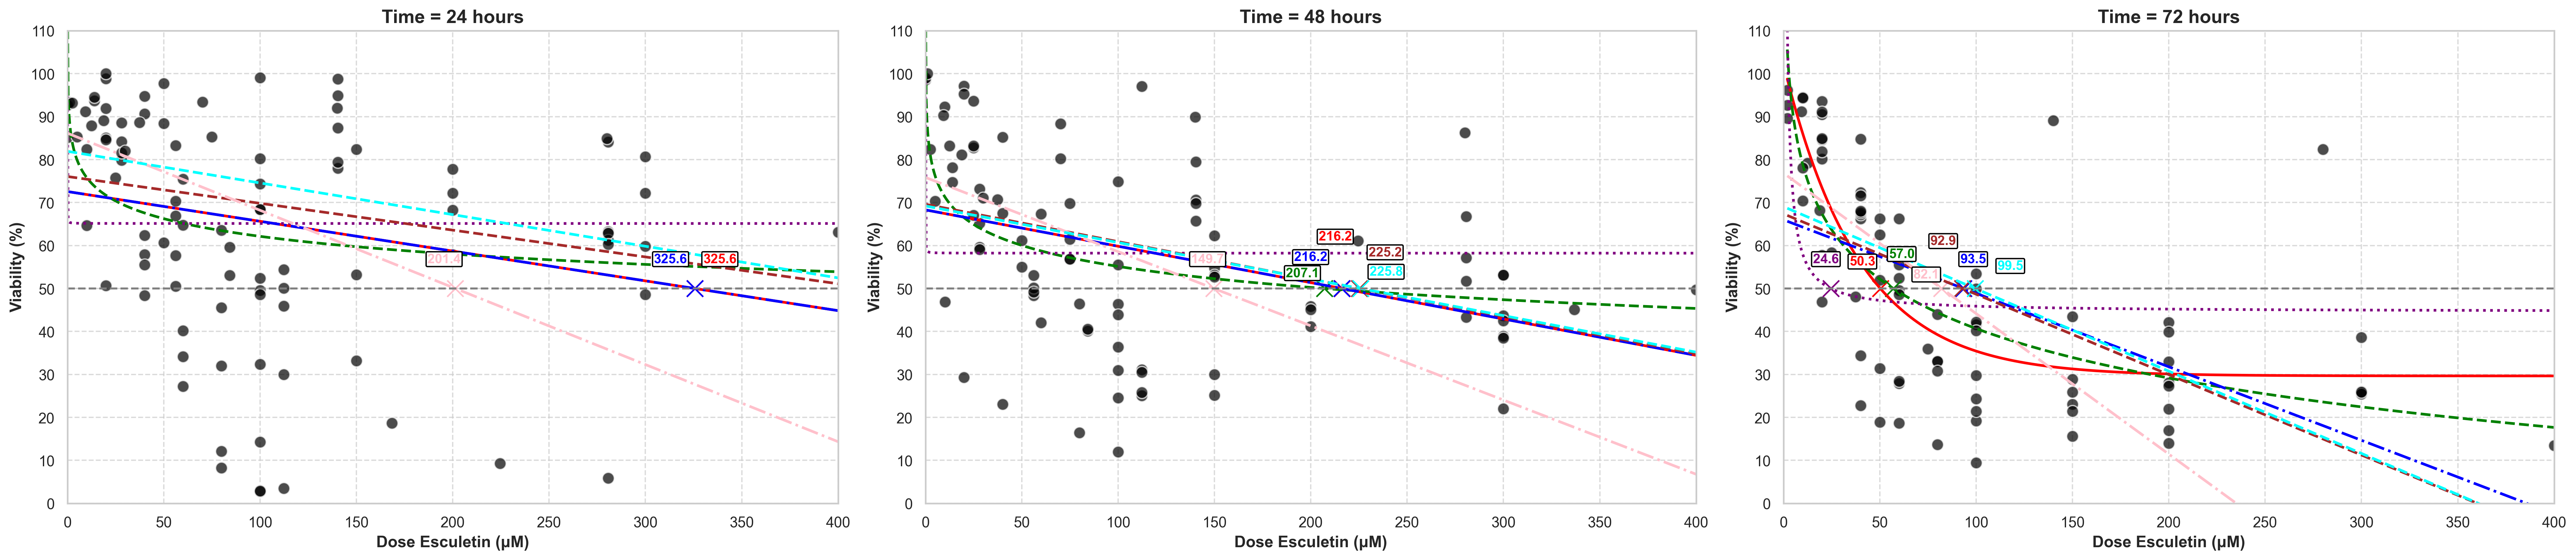

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root_scalar
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, QuantileRegressor
import pandas as pd
import seaborn as sns
from adjustText import adjust_text  # Import adjustText
# Suppress specific warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignore FutureWarnings
warnings.filterwarnings('ignore', category=UserWarning)    # Ignore UserWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning) # Ignore RuntimeWarnings

# Set Seaborn style for better visuals
sns.set(style="whitegrid", palette="muted")

# Load the dataset
file_path = '/home/arashp/Programming_Files/ML_Paper/Total_Data.csv'
df = pd.read_csv(file_path)

# Ensure Coumarin Dose is numeric
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Define models
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def log_decay(x, a, b):
    return a * np.log(x) + b

def inverse_func(x, a, b):
    return a / x + b

# Function to find the dose for a specific viability
def find_dose_for_viability(func, params, x_data, target_viability=50):
    if np.any(np.isnan(params)) or np.any(np.isinf(params)):
        return None
    try:
        bracket = [max(min(x_data), 1e-5), max(x_data)]
        root_result = root_scalar(lambda x: func(x, *params) - target_viability, bracket=bracket)
        return root_result.root if root_result.converged else None
    except:
        return None

# Prepare the plot
fig, axs = plt.subplots(1, 3, figsize=(27, 6), dpi=300)
time_points = [24, 48, 72]

for i, time in enumerate(time_points):
    df_filtered = df[(df['Time'] == time) & (df['Coumarin Dose'] <= 400) & (df['Coumarin Type'] == 'Esculetin')]
    x_data = df_filtered['Coumarin Dose'].values.reshape(-1, 1)
    y_data = df_filtered['Viability'].values

    positive_mask = x_data.ravel() > 0
    positive_x = x_data[positive_mask]
    positive_y = y_data[positive_mask]

    # Fit regression models
    models = {
        "Linear Regression": LinearRegression(),
        "Huber Regression": HuberRegressor(),
        #"RANSAC Regression": RANSACRegressor(),
        "Theil-Sen Estimator": TheilSenRegressor(),
        "Quantile Regression": QuantileRegressor(quantile=0.5, solver="highs"),
    }
    
    for name, model in models.items():
        model.fit(x_data, y_data)
        models[name] = model
        
        # Access the estimator_ for RANSACRegressor
        if hasattr(model, 'estimator_'):
            estimator = model.estimator_
            intercept = estimator.intercept_
            slope = estimator.coef_[0]
        else:
            intercept = model.intercept_
            slope = model.coef_[0]
        
        print(f"{name} Coefficients: Intercept={intercept:.4f}, Slope={slope:.4f}")

    # Exponential Decay fit coefficients
    try:
        params_exp, _ = curve_fit(exp_decay, x_data.ravel(), y_data, maxfev=10000)
        print(f"Exponential Decay Coefficients: a={params_exp[0]:.4f}, b={params_exp[1]:.4f}, c={params_exp[2]:.4f}")
    except:
        print("Exponential Decay fit failed.")

    # Logarithmic Decay fit coefficients
    try:
        params_log, _ = curve_fit(log_decay, positive_x.ravel(), positive_y, maxfev=10000)
        print(f"Logarithmic Decay Coefficients: a={params_log[0]:.4f}, b={params_log[1]:.4f}")
    except:
        print("Logarithmic Decay fit failed.")

    # Inverse Function fit coefficients
    try:
        params_inv, _ = curve_fit(inverse_func, positive_x.ravel(), positive_y, maxfev=10000)
        print(f"Inverse Function Coefficients: a={params_inv[0]:.4f}, b={params_inv[1]:.4f}\n-------------------")
    except:
        print("Inverse Function fit failed.")
    
    # Generate x values for predictions
    x_fit = np.linspace(max(1e-5, min(x_data.ravel())), max(x_data.ravel()), 1000).reshape(-1, 1)
    
    y_fits = {
        "Exponential Decay": exp_decay(x_fit.ravel(), *params_exp),
        "Logarithmic Decay": log_decay(x_fit[x_fit > 0].ravel(), *params_log),
        "Inverse Function": inverse_func(x_fit[x_fit > 0].ravel(), *params_inv),
    }
    
    for name, model in models.items():
        y_fits[name] = model.predict(x_fit)

    # Plot data points
    axs[i].scatter(x_data, y_data, label='Data Points', color='black', s=80, edgecolors='white', alpha=0.7)
    axs[i].grid(axis="both", linestyle="--", alpha=0.7)
    
    # Line styles for clarity
    line_styles = {
        "Exponential Decay": ('red', '-'),
        "Logarithmic Decay": ('green', '--'),
        "Inverse Function": ('purple', ':'),
        "Linear Regression": ('blue', '-.'),
        "Huber Regression": ('brown', '--'),
        #"RANSAC Regression": ('orange', ':'),
        "Theil-Sen Estimator": ('pink', '-.'),
        "Quantile Regression": ('cyan', '--'),
    }
    
    # Collect text labels for adjustment
    texts = []
    
    for name, (color, style) in line_styles.items():
        if name in y_fits:
            axs[i].plot(x_fit, y_fits[name], color=color, linestyle=style, linewidth=2, label=name)

            # Find dose for 50% viability
            if name == "Exponential Decay":
                dose_50 = find_dose_for_viability(exp_decay, params_exp, x_data.ravel())
            elif name == "Logarithmic Decay":
                dose_50 = find_dose_for_viability(log_decay, params_log, x_data.ravel())
            elif name == "Inverse Function":
                dose_50 = find_dose_for_viability(inverse_func, params_inv, x_data.ravel())
            else:
                dose_50 = (50 - models[name].intercept_) / models[name].coef_[0] if hasattr(models[name], "coef_") else None

            # Highlight dose for 50% viability with black border
            if dose_50 is not None and 0 < dose_50 <= 400:
                axs[i].scatter(dose_50, 50, color=color, marker='x', s=150, edgecolors='black', linewidth=1.2)
                text = axs[i].text(dose_50, 55, f"{dose_50:.1f}", color=color, fontsize=10, ha='center', weight='bold', 
                                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
                texts.append(text)  # Add the text object to the list

    axs[i].set_ylim(0, 110)
    axs[i].set_xlim(0, 400)
    axs[i].set_yticks(range(0, 111, 10))
    axs[i].set_xticks(range(0, 401, 50))
    axs[i].set_xlabel('Dose Esculetin (μM)', fontsize=12, weight='bold')
    axs[i].set_ylabel('Viability (%)', fontsize=12, weight='bold')
    axs[i].axhline(y=50, color='gray', linestyle='--', label='Viability = 50')
    #axs[i].legend()
    axs[i].set_title(f'Time = {time} hours', fontsize=14, weight='bold')

    # Use adjustText to prevent text overlap without arrows
    adjust_text(texts, ax=axs[i], only_move={'points': 'y', 'text': 'xy'}, expand_text=(1.05, 1.05), force_text=(0.3, 0.3))

plt.tight_layout()
# plt.savefig('/Users/sadra/Downloads/time_Esculetin_styled.tiff', format='tiff', dpi=300)
plt.show()

### Bubble plot

#### Umb

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/sadra/Desktop/Cell Lines/Data/Total_Data.csv'
df = pd.read_csv(file_path)

df = df[df['Coumarin Dose'] <= 400]
df = df[df['Time'] <= 72]
df = df[df['Viability'] <= 100]

# Convert 'Coumarin Dose' to numeric, coercing errors to NaN
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Filter the DataFrame to include only rows where Coumarin Type is 'Umbelliprenin' and Coumarin Dose is less than 1200
df_filtered = df[(df['Coumarin Type'] == 'Umbelliprenin') & (df['Coumarin Dose'] < 1200)]

# Plot
plt.figure(figsize=(15, 10), dpi=300)

# Scatter plot with Coumarin Dose on x-axis and Viability on y-axis
# Time is represented by bubble size and color
scatter = plt.scatter(
    df_filtered['Coumarin Dose'], df_filtered['Viability'],
    c=df_filtered['Time'], s=df_filtered['Time']*10,  # Bubble size scaled by Time
    cmap='RdBu', alpha=0.8, edgecolors='black', linewidth=0.7, marker='o'  # 'o' for circles
)

# Add a color bar to indicate the Time values
plt.colorbar(scatter, label='Time (hours)')

# Add a black horizontal line at 50% viability
plt.axhline(y=50, color='black', linestyle='--', linewidth=2)

# Set the y-axis range from 0 to 110
plt.ylim(0, 110)

# Set the x-axis range from 0 to 1200
plt.xlim(0, 400)

# Set x-axis ticks to increase by 100
plt.xticks(range(0, 401, 25))

# Set y-axis ticks to increase by 10
plt.yticks(range(0, 111, 10))

# Set axis labels and plot title
plt.xlabel('Dose Umbelliprenin (μM)', fontsize=14)
plt.ylabel('Viability (%)', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
plt.savefig('/Users/sadra/Downloads/Enhanced_Bubble_Umbelliprenin_Circles.tiff', format='tiff')
print('Enhanced scatter plot saved as TIFF file.')

#### GBA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/home/arashp/Programming_Files/ML_Paper/Total_Data.csv'
df = pd.read_csv(file_path)

df = df[df['Coumarin Dose'] <= 400]
df = df[df['Time'] <= 72]
df = df[df['Viability'] <= 100]

# Convert 'Coumarin Dose' to numeric, coercing errors to NaN
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Filter the DataFrame to include only rows where Coumarin Type is 'Galbanic Acid' and Coumarin Dose is less than 1200
df_filtered = df[(df['Coumarin Type'] == 'Galbanic Acid')]

# Plot
plt.figure(figsize=(15, 10), dpi=300)

# Scatter plot with Coumarin Dose on x-axis and Viability on y-axis
# Time is represented by bubble size and color
scatter = plt.scatter(
    df_filtered['Coumarin Dose'], df_filtered['Viability'],
    c=df_filtered['Time'], s=df_filtered['Time']*10,  # Bubble size scaled by Time
    cmap='RdBu', alpha=0.8, edgecolors='black', linewidth=0.7, marker='o'  # 'o' for circles
)

# Add a color bar to indicate the Time values
plt.colorbar(scatter, label='Time (hours)')

# Add a black horizontal line at 50% viability
plt.axhline(y=50, color='black', linestyle='--', linewidth=2)

# Set the y-axis range from 0 to 110
plt.ylim(0, 110)

# Set the x-axis range from 0 to 1200
plt.xlim(0, 400)

# Set x-axis ticks to increase by 100
plt.xticks(range(0, 401, 25))

# Set y-axis ticks to increase by 10
plt.yticks(range(0, 111, 10))

# Set axis labels and plot title
plt.xlabel('Dose Galbanic Acid (μM)', fontsize=14)
plt.ylabel('Viability (%)', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
# plt.savefig('/Users/sadra/Downloads/Enhanced_Bubble_Galbanic_Acid_Circles.tiff', format='tiff')
print('Enhanced scatter plot saved as TIFF file.')

#### Esc

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/home/arashp/Programming_Files/ML_Paper/Total_Data.csv'
df = pd.read_csv(file_path)

df = df[df['Coumarin Dose'] <= 400]
df = df[df['Time'] <= 72]
df = df[df['Viability'] <= 100]

# Convert 'Coumarin Dose' to numeric, coercing errors to NaN
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Filter the DataFrame to include only rows where Coumarin Type is 'Esculetin' and Coumarin Dose is less than 1200
df_filtered = df[(df['Coumarin Type'] == 'Esculetin')]

# Plot
plt.figure(figsize=(15, 10), dpi=300)

# Scatter plot with Coumarin Dose on x-axis and Viability on y-axis
# Time is represented by bubble size and color
scatter = plt.scatter(
    df_filtered['Coumarin Dose'], df_filtered['Viability'],
    c=df_filtered['Time'], s=df_filtered['Time']*10,  # Bubble size scaled by Time
    cmap='RdBu', alpha=0.8, edgecolors='black', linewidth=0.7, marker='o'  # 'o' for circles
)

# Add a color bar to indicate the Time values
plt.colorbar(scatter, label='Time (hours)')

# Add a black horizontal line at 50% viability
plt.axhline(y=50, color='black', linestyle='--', linewidth=2)

# Set the y-axis range from 0 to 110
plt.ylim(0, 110)

# Set the x-axis range from 0 to 1200
plt.xlim(0, 400)

# Set x-axis ticks to increase by 100
plt.xticks(range(0, 401, 25))

# Set y-axis ticks to increase by 10
plt.yticks(range(0, 111, 10))

# Set axis labels and plot title
plt.xlabel('Dose Esculetin (μM)', fontsize=14)
plt.ylabel('Viability (%)', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
plt.show()
# plt.savefig('/Users/sadra/Downloads/Enhanced_Bubble_Esculetin_Circles.tiff', format='tiff')
print('Enhanced scatter plot saved as TIFF file.')

#### Aur

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/sadra/Desktop/Cell Lines/Data/Total_Data.csv'
df = pd.read_csv(file_path)

df = df[df['Coumarin Dose'] <= 400]
df = df[df['Time'] <= 72]
df = df[df['Viability'] <= 100]

# Convert 'Coumarin Dose' to numeric, coercing errors to NaN
df['Coumarin Dose'] = pd.to_numeric(df['Coumarin Dose'], errors='coerce')

# Filter the DataFrame to include only rows where Coumarin Type is 'Auraptene' and Coumarin Dose is less than 1200
df_filtered = df[(df['Coumarin Type'] == 'Auraptene')]

# Plot
plt.figure(figsize=(15, 10), dpi=300)

# Scatter plot with Coumarin Dose on x-axis and Viability on y-axis
# Time is represented by bubble size and color
scatter = plt.scatter(
    df_filtered['Coumarin Dose'], df_filtered['Viability'],
    c=df_filtered['Time'], s=df_filtered['Time']*10,  # Bubble size scaled by Time
    cmap='RdBu', alpha=0.8, edgecolors='black', linewidth=0.7, marker='o'  # 'o' for circles
)

# Add a color bar to indicate the Time values
plt.colorbar(scatter, label='Time (hours)')

# Add a blue horizontal line at 50% viability
plt.axhline(y=50, color='black', linestyle='--', linewidth=2)

# Set the y-axis range from 0 to 110
plt.ylim(0, 110)

# Set the x-axis range from 0 to 1200
plt.xlim(0, 400)

# Set x-axis ticks to increase by 100
plt.xticks(range(0, 401, 25))

# Set y-axis ticks to increase by 10
plt.yticks(range(0, 111, 10))

# Set axis labels and plot title
plt.xlabel('Dose Auraptene (μM)', fontsize=14)
plt.ylabel('Viability (%)', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
plt.savefig('/Users/sadra/Downloads/Enhanced_Bubble_Auraptene_Circles.tiff', format='tiff')
print('Enhanced scatter plot saved as PNG file.')

### Flowchart

In [ ]:
from graphviz import Digraph

# Simplified, high-level multi-model workflow

dot = Digraph(
    format="tiff",
    graph_attr={
        "rankdir": "LR",
        "splines": "ortho",
        "dpi": "300",
        "size": "12,4",
        "ranksep": "0.6",
        "nodesep": "0.45"
    },
    node_attr={
        "style": "solid",
        "color": "black",
        "fontsize": "13",
        "fontname": "Arial",
        "width": "1.8",
        "height": "0.9",
        "shape": "box"
    },
    edge_attr={"fontsize": "10", "fontstyle": "italic"}
)

# === Nodes (high-level only) ===
dot.node("Load", "Load Dataset")
dot.node(
    "Filter",
    "Filter Dose ≤ 400\n& Time Points:\n- Auraptene: 24, 48, 72, 96 h\n- Esculetin, Umbelliprenin,\n  Galbanic Acid: 24, 48, 72 h"
)
dot.node("Encode", "Encode Cancer Types (LabelEncoder)")
dot.node("Loop", "Iterate Over Each Coumarin Type")
dot.node("Reliability", "Reliability Filtering\n(Gaussian Mixture Model)")
dot.node("Train", "Train 4 ML Models\n(With 5-Fold CV)")
dot.node("Predict", "Generate Model Predictions\n(Optimal Viability ≈ 50%)")
dot.node("Aggregate", "Weighted Median Aggregation\nAcross All Models")
dot.node("Output", "Final Recommended\nDose & Time per Cancer Type")

# === Edges ===
dot.edge("Load", "Filter")
dot.edge("Filter", "Encode")
dot.edge("Encode", "Loop")
dot.edge("Loop", "Reliability")
dot.edge("Reliability", "Train")
dot.edge("Train", "Predict")
dot.edge("Predict", "Aggregate")
dot.edge("Aggregate", "Output")

# === Render ===
output_path = '/Users/sadra/Downloads/Coumarin_Workflow_Compact'
dot.render(output_path, cleanup=True)
print(f"Flowchart saved as {output_path}.tiff")


### Treemap

#### Coumarin

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # For tree map

# Load the dataset
file_path = '/Users/sadra/Desktop/Cell Lines/Data/Total_Data.csv'
df = pd.read_csv(file_path)

# === FILTERS ===
df = df[df['Coumarin Dose'] <= 400]
df = df[df['Time'].isin([24, 48, 72])]
df = df[df['Viability'] <= 100]

# Coumarin Type Counts
counts = df['Coumarin Type'].value_counts()
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Combine Counts and Percentages in Labels
labels = [
    f"{name}\n({count}) ({percentage}%)"
    for name, count, percentage in zip(counts.index, counts.values, percentages)
]

# Normalize the sizes to calculate relative font sizes
sizes = counts.values
min_size = min(sizes)
max_size = max(sizes)
font_sizes = [
    10 + (20 * (size - min_size) / (max_size - min_size)) if max_size != min_size else 12
    for size in sizes
]

# Tree Map Plot with Dynamic Font Sizes
fig, ax = plt.subplots(figsize=(12, 8))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=plt.cm.tab20.colors[:len(counts)],
    alpha=0.8,
    text_kwargs={'fontsize': None},
    ax=ax
)

# Apply dynamic font sizes
for text, font_size in zip(ax.texts, font_sizes):
    text.set_fontsize(font_size)

# Remove Axes
ax.axis('off')

# Save the Tree Map
save_path = '/Users/sadra/Downloads/Coumarin_Type_tree_map_excluding_scopoletin_dynamic_fonts.tiff'
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Tree map for Coumarin Type saved at {save_path}")

#### Cancer

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # For tree map

# Load dataset
file_path = '/Users/sadra/Desktop/Cell Lines/Data/Total_Data.csv'
df = pd.read_csv(file_path)

# === EXCLUDE SCOPOLETIN FIRST ===
df = df[df['Coumarin Type'] != 'Scopoletin']

# === FILTERS ===
df = df[df['Coumarin Dose'] <= 400]
df = df[df['Time'].isin([24, 48, 72])]
df = df[df['Viability'] <= 100]

# Cancer Type Counts and Percentages
counts = df['Cancer Type'].value_counts()
total_count = counts.sum()
percentages = (counts / total_count * 100).round(1)

# Combine Counts and Percentages in Labels
labels = [
    f"{cancer_type}\n({count}) ({percentage}%)"
    for cancer_type, count, percentage in zip(counts.index, counts.values, percentages)
]

# Tree Map Plot
fig, ax = plt.subplots(figsize=(24, 16))
rects = squarify.normalize_sizes(counts.values, 100, 100)
positions = squarify.squarify(rects, 0, 0, 100, 100)

# Adjust font size based on area
areas = [rect['dx'] * rect['dy'] for rect in positions]
font_sizes = [max(12, (area ** 0.5) * 0.5) for area in areas]  # Scale and set minimum font size

# Draw Tree Map with Bold Labels
num_colors = len(plt.cm.tab20.colors)
for pos, label, font_size, index in zip(positions, labels, font_sizes, range(len(labels))):
    x, y, dx, dy = pos['x'], pos['y'], pos['dx'], pos['dy']
    color = plt.cm.tab20.colors[index % num_colors]  # Wrap colors if labels exceed 20
    ax.add_patch(plt.Rectangle((x, y), dx, dy, color=color, alpha=0.8))
    
    ax.text(
        x + dx / 2,
        y + dy / 2,
        label,
        ha='center',
        va='center',
        fontsize=font_size,
        fontweight='bold',
        wrap=True
    )

# Remove Axes
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.axis('off')

# Save the Tree Map
save_path = '/Users/sadra/Downloads/Cancer_Type_tree_map_excluding_scopoletin.tiff'
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Tree map for Cancer Types saved at {save_path}")